## Delivery Route Planner: An AI, Machine Learning, and Constraint Satisfaction Project

## Abstract

Efficient delivery operations are critical for modern e‑commerce companies.
This project explores how classical **search algorithms** (e.g., breadth‑first search, depth‑first search and A* search), **constraint satisfaction** techniques, and **machine learning** can be applied to plan delivery routes.
Using a real Amazon delivery dataset (`amazon_delivery.csv`), we formulate a route‑planning problem in which a single agent must visit multiple drop locations once while minimizing travel distance and obeying practical constraints such as blocked roads and delivery time windows.

After exploring the data, we implement search methods to solve two problems: finding efficient paths between individual locations on a grid with obstacles and computing an order in which to visit multiple customers.
We then incorporate **time windows** as additional constraints and solve the resulting scheduling problem using backtracking.
Additionally, we employ **machine learning** (Random Forest regression) to predict travel times based on distance, traffic, weather, and other factors, demonstrating how ML can enhance classical AI algorithms.
Our results include route maps, performance comparisons of the algorithms, and ML model evaluation metrics.
The notebook concludes with a discussion of the findings, limitations and future work.

## Introduction

**Problem:** Plan optimal delivery routes visiting multiple locations while minimizing distance and satisfying constraints (time windows, blocked roads).

**Approach:**
1. **Search Algorithms:** BFS, DFS, A*, and Greedy solve the Traveling Salesman Problem variant
2. **Constraint Satisfaction:** Backtracking handles time window constraints
3. **Machine Learning:** Random Forest predicts travel times from historical data

**AI Concepts Used:**
- **Search problems:** State space, successor function, goal test, action costs
- **Uninformed search:** BFS (level-by-level), DFS (depth-first)
- **Informed search:** A* (heuristic-guided, optimal)
- **CSP:** Variables (delivery locations), domains (visit orders), constraints (time windows, visit-once)


## Background and Related Work

### Search Algorithms

- **BFS:** Explores level-by-level, finds shortest path in unweighted graphs
- **DFS:** Explores depth-first, memory-efficient but not optimal
- **A*:** Informed search using f(n)=g(n)+h(n). Optimal when heuristic is admissible and consistent
- **Greedy:** Fast heuristic, may sacrifice optimality

### Constraint Satisfaction Problems (CSP)

- **Variables:** Delivery locations and visit times
- **Domains:** Possible visit orders
- **Constraints:** Visit each location once, satisfy time windows
- **Solution:** Backtracking with forward checking

### Vehicle Routing Problem (VRP)

- **TSP:** Single vehicle visits all locations once (NP-hard)
- **VRP:** Multiple vehicles with capacity and time constraints
- **Our approach:** TSP variant with time windows using AI search and CSP


## Data Exploration

**Dataset:** 43,739 Amazon delivery orders

**Features:**
- Store and drop-off coordinates (latitude/longitude)
- Order and pickup times
- Delivery time (minutes)
- Traffic conditions (Low, Medium, High, Jam)
- Weather conditions (Sunny, Cloudy, Stormy, Fog, Windy, Sandstorms)
- Agent age and rating
- Vehicle type and delivery category

In [31]:
# Load the dataset
import pandas as pd
import numpy as np

file_path = 'amazon_delivery.csv'
df = pd.read_csv(file_path)

# Display basic information
print("Number of orders:", len(df))

df.head()

Number of orders: 43739


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


DATASET SUMMARY STATISTICS

Numerical Features:
           Agent_Age  Agent_Rating  Delivery_Time
count   43739.000000  43685.000000   43739.000000
unique           NaN           NaN            NaN
top              NaN           NaN            NaN
freq             NaN           NaN            NaN
mean       29.567137      4.633780     124.905645
std         5.815155      0.334716      51.915451
min        15.000000      1.000000      10.000000
25%        25.000000      4.500000      90.000000
50%        30.000000      4.700000     125.000000
75%        35.000000      4.900000     160.000000
max        50.000000      6.000000     270.000000

CATEGORICAL DISTRIBUTIONS

Top areas:
 Area
Metropolitian     32698
Urban              9751
Other              1138
Semi-Urban          152
Name: count, dtype: int64

Top categories:
 Category
Electronics    2849
Books          2824
Jewelry        2802
Toys           2781
Skincare       2772
Name: count, dtype: int64

Traffic levels:
 Traffic
Low   

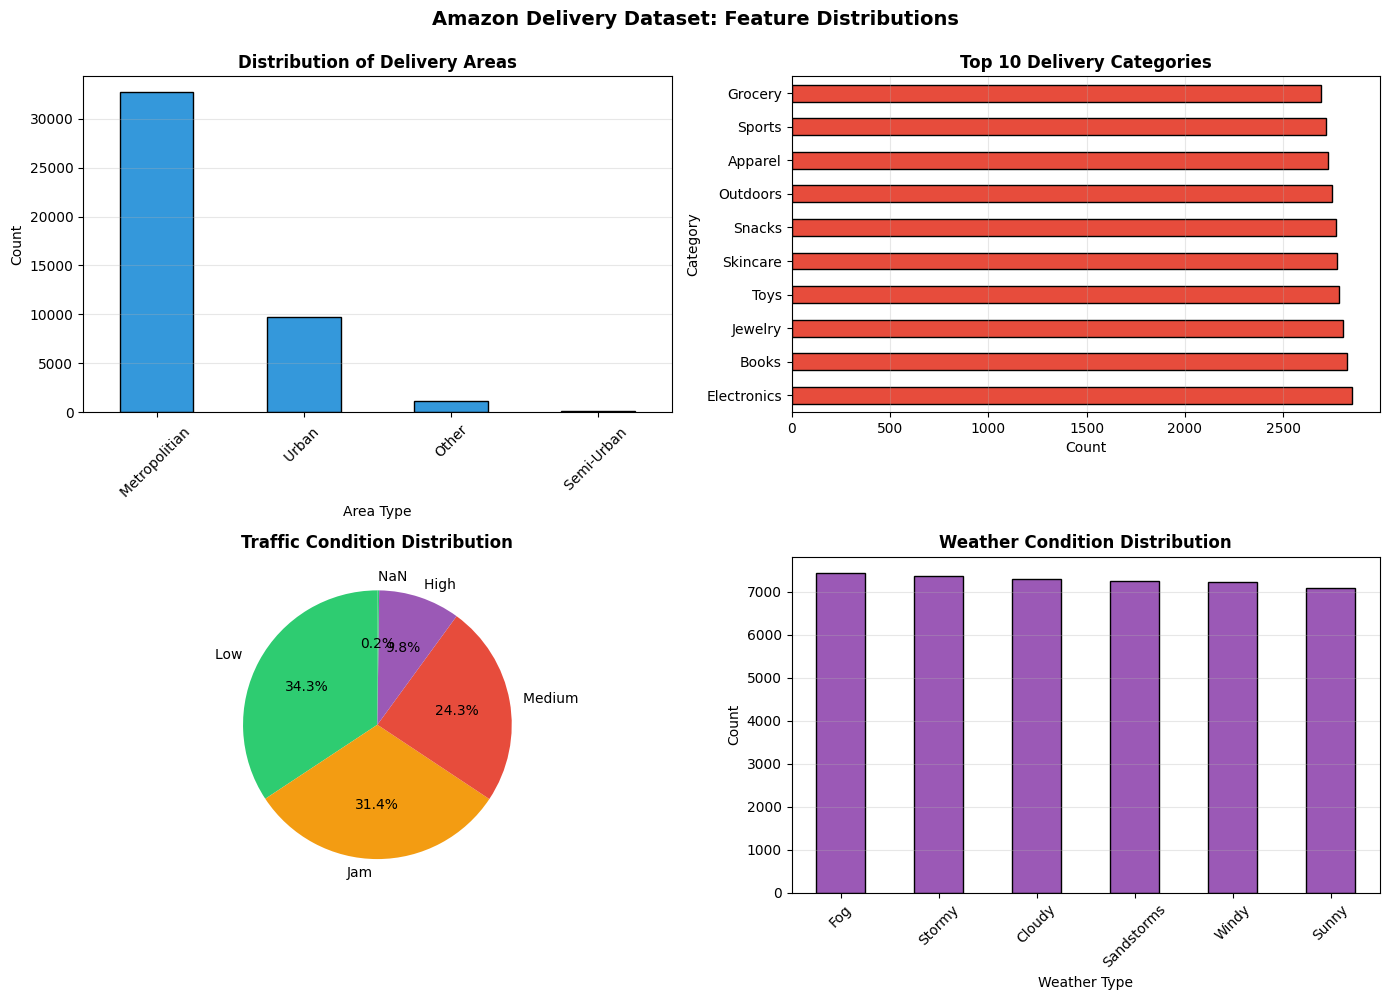

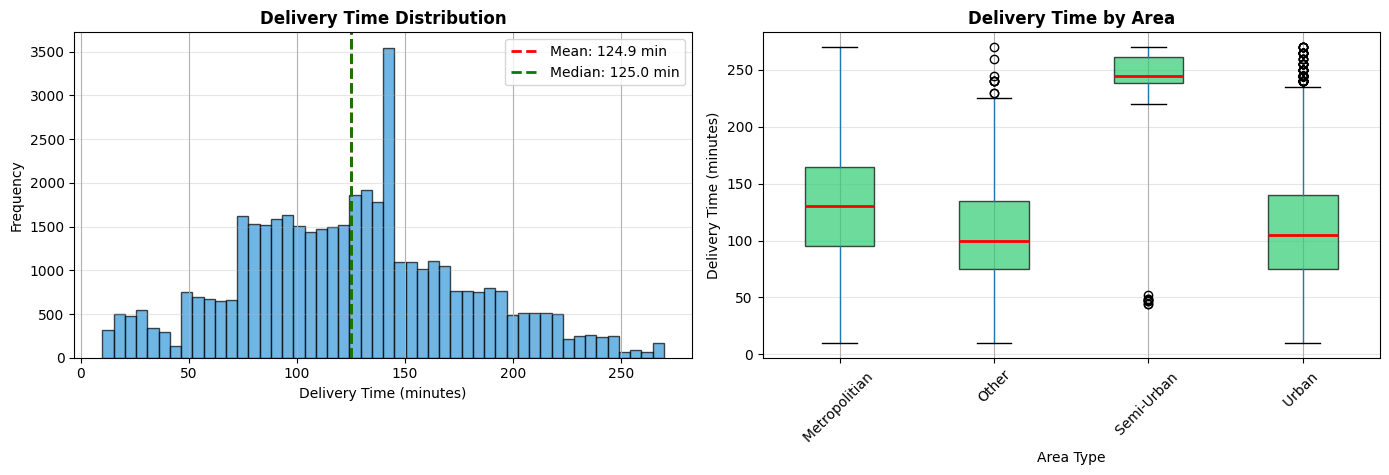

In [32]:
# Enhanced data exploration with visualizations
import matplotlib.pyplot as plt

summary = df.describe(include='all')
area_counts = df['Area'].value_counts()
category_counts = df['Category'].value_counts()
traffic_counts = df['Traffic'].value_counts()
weather_counts = df['Weather'].value_counts()

print("="*70)
print("DATASET SUMMARY STATISTICS")
print("="*70)
print("\nNumerical Features:")
print(summary[['Agent_Age','Agent_Rating','Delivery_Time']])
print('\n' + "="*70)
print("CATEGORICAL DISTRIBUTIONS")
print("="*70)
print('\nTop areas:\n', area_counts.head())
print('\nTop categories:\n', category_counts.head())
print('\nTraffic levels:\n', traffic_counts.head())
print('\nWeather conditions:\n', weather_counts.head())

# Enhanced visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Area distribution
ax1 = axes[0, 0]
area_counts.plot(kind='bar', ax=ax1, color='#3498db', edgecolor='black')
ax1.set_title('Distribution of Delivery Areas', fontsize=12, fontweight='bold')
ax1.set_xlabel('Area Type', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Category distribution (top 10)
ax2 = axes[0, 1]
category_counts.head(10).plot(kind='barh', ax=ax2, color='#e74c3c', edgecolor='black')
ax2.set_title('Top 10 Delivery Categories', fontsize=12, fontweight='bold')
ax2.set_xlabel('Count', fontsize=10)
ax2.set_ylabel('Category', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

# Traffic distribution
ax3 = axes[1, 0]
traffic_counts_clean = traffic_counts.dropna()
traffic_counts_clean.plot(kind='pie', ax=ax3, autopct='%1.1f%%', 
                         colors=['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'],
                         startangle=90)
ax3.set_title('Traffic Condition Distribution', fontsize=12, fontweight='bold')
ax3.set_ylabel('')

# Weather distribution
ax4 = axes[1, 1]
weather_counts.plot(kind='bar', ax=ax4, color='#9b59b6', edgecolor='black')
ax4.set_title('Weather Condition Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Weather Type', fontsize=10)
ax4.set_ylabel('Count', fontsize=10)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Amazon Delivery Dataset: Feature Distributions', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Delivery time analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
df['Delivery_Time'].hist(bins=50, ax=ax1, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(df['Delivery_Time'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {df["Delivery_Time"].mean():.1f} min')
ax1.axvline(df['Delivery_Time'].median(), color='green', linestyle='--', 
           linewidth=2, label=f'Median: {df["Delivery_Time"].median():.1f} min')
ax1.set_title('Delivery Time Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Delivery Time (minutes)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Box plot by area
ax2 = axes[1]
df.boxplot(column='Delivery_Time', by='Area', ax=ax2, patch_artist=True,
          boxprops=dict(facecolor='#2ecc71', alpha=0.7),
          medianprops=dict(color='red', linewidth=2))
ax2.set_title('Delivery Time by Area', fontsize=12, fontweight='bold')
ax2.set_xlabel('Area Type', fontsize=10)
ax2.set_ylabel('Delivery Time (minutes)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
plt.suptitle('')  # Remove default title
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

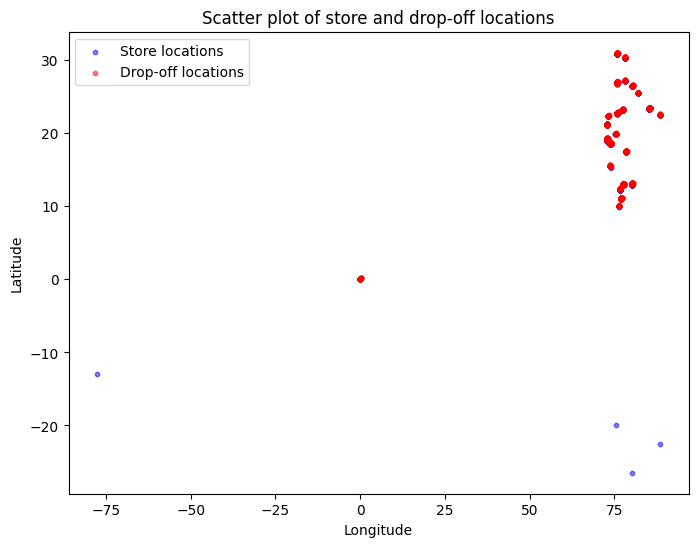

In [33]:
import matplotlib.pyplot as plt

# sample a subset for plotting to avoid overcrowding
sample = df.sample(n=1000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(sample['Store_Longitude'], sample['Store_Latitude'], c='blue', s=10, alpha=0.5, label='Store locations')
plt.scatter(sample['Drop_Longitude'], sample['Drop_Latitude'], c='red', s=10, alpha=0.5, label='Drop-off locations')
plt.title('Scatter plot of store and drop-off locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### Key Observations

- **Geographic:** 74.8% metropolitan, 22.3% urban areas
- **Delivery Time:** Average 124.9 min, range 10-270 min
- **Traffic:** Distributed across Low (34%), Jam (31%), Medium (24%), High (10%)
- **Weather:** Evenly distributed (Fog, Stormy, Cloudy, Sandstorms, Windy)

### Problem Formulation

**Subset Selection:** 8 deliveries from Urban area (tractable for exact algorithms)

**Distance Calculation:** Haversine formula computes pairwise distances between drop locations

**Objective:** Find visit order minimizing total distance while satisfying constraints

In [34]:
from math import radians, sin, cos, sqrt, asin

# Select a subset of N deliveries from the Urban area for demonstration
N = 8  # number of drop locations to plan
subset = df[df['Area'].str.strip() == 'Urban'].sample(n=N, random_state=0).reset_index(drop=True)

# Compute the Haversine distance between two points on Earth (in km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Build distance matrix between drop locations
coords = list(zip(subset['Drop_Latitude'], subset['Drop_Longitude']))

n = len(coords)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i == j:
            dist = 0
        else:
            dist = haversine(coords[i][0], coords[i][1], coords[j][0], coords[j][1])
        dist_matrix[i][j] = dist

# Display the subset and distance matrix
subset[['Order_ID','Drop_Latitude','Drop_Longitude','Delivery_Time']]

,Order_ID,Drop_Latitude,Drop_Longitude,Delivery_Time
0,vvcz078314566,22.340329,73.199083,125
1,kccb341922577,25.522350,81.911889,80
2,gwkf386025425,22.420526,73.280937,225
3,tkeq575876631,21.177735,72.788778,85
4,uxdm841197176,12.383225,76.690028,80
5,hyrs563103877,9.979778,76.316106,70
6,buah715484957,23.343017,85.327200,75
7,atzt544450602,26.931378,75.809034,60


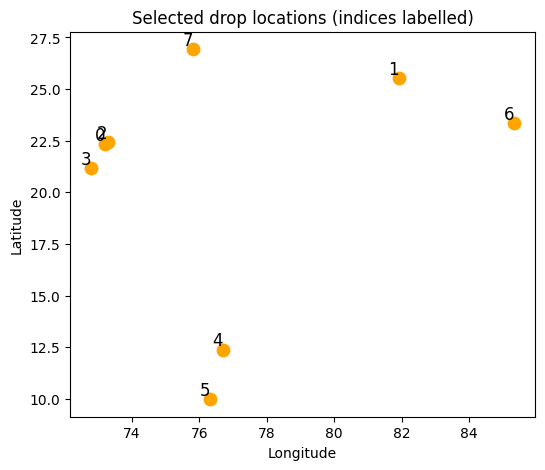

In [35]:
# Visualize the selected drop locations on a scatter plot
plt.figure(figsize=(6,5))
for i, (lat, lon) in enumerate(coords):
    plt.scatter(lon, lat, c='orange', s=80)
    plt.text(lon, lat, str(i), fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.title('Selected drop locations (indices labelled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Route Planning Problem

**Problem:** TSP variant - visit all drop locations once, minimize total distance

**State:** (current_location, visited_set, route, cost)

**Successor:** Visit any unvisited location

**Cost:** Haversine distance between locations

**Algorithms Implemented:**
- BFS/DFS: Exhaustive search (optimal)
- Greedy: Nearest-neighbor heuristic (fast)
- A*: Heuristic search with lower-bound estimate (optimal, efficient)


In [36]:
from collections import deque
import math

# BFS route search (find minimum cost route visiting all nodes starting at 0)
def bfs_route(distance_matrix):
    n = len(distance_matrix)
    start = 0
    best_route, best_cost = None, float('inf')
    # state = (current_node, visited_set, route_list, cost)
    initial_state = (0, frozenset([0]), [0], 0.0)
    queue = deque([initial_state])
    while queue:
        current_node, visited, route, cost = queue.popleft()
        if len(visited) == n:
            full_cost = cost + distance_matrix[current_node][start]
            if full_cost < best_cost:
                best_cost = full_cost
                best_route = route.copy()
            continue
        for next_node in range(1, n):
            if next_node not in visited:
                new_cost = cost + distance_matrix[current_node][next_node]
                if new_cost >= best_cost:
                    continue
                new_route = route + [next_node]
                new_visited = visited | {next_node}
                queue.append((next_node, new_visited, new_route, new_cost))
    return best_route, best_cost

# DFS route search (uses stack; explores depth-first)
def dfs_route(distance_matrix):
    n = len(distance_matrix)
    start = 0
    best_route, best_cost = None, float('inf')
    stack = [(0, frozenset([0]), [0], 0.0)]
    while stack:
        current_node, visited, route, cost = stack.pop()
        if len(visited) == n:
            full_cost = cost + distance_matrix[current_node][start]
            if full_cost < best_cost:
                best_cost = full_cost
                best_route = route.copy()
            continue
        for next_node in range(1, n):
            if next_node not in visited:
                new_cost = cost + distance_matrix[current_node][next_node]
                if new_cost >= best_cost:
                    continue
                new_route = route + [next_node]
                new_visited = visited | {next_node}
                stack.append((next_node, new_visited, new_route, new_cost))
    return best_route, best_cost

# Greedy nearest neighbour heuristic
def greedy_route(distance_matrix):
    n = len(distance_matrix)
    current = 0
    visited = {0}
    route = [0]
    total_cost = 0.0
    while len(visited) < n:
        next_node = None
        best_dist = float('inf')
        for j in range(1, n):
            if j not in visited and distance_matrix[current][j] < best_dist:
                best_dist = distance_matrix[current][j]
                next_node = j
        route.append(next_node)
        total_cost += best_dist
        visited.add(next_node)
        current = next_node
    total_cost += distance_matrix[current][0]
    return route, total_cost

# A* search for TSP using a simple heuristic
import heapq
def astar_route(distance_matrix):
    n = len(distance_matrix)
    start = 0
    def heuristic(current_node, visited):
        unvisited = [i for i in range(n) if i not in visited]
        if not unvisited:
            return distance_matrix[current_node][start]
        min_to_unvisited = min(distance_matrix[current_node][i] for i in unvisited)
        est = 0
        for i in unvisited:
            neighbours = [distance_matrix[i][j] for j in unvisited if j != i]
            if neighbours:
                est += min(neighbours)
        return min_to_unvisited + est
    open_set = []
    visited_states = {}
    initial_h = heuristic(start, frozenset([0]))
    heapq.heappush(open_set, (initial_h, 0.0, 0, frozenset([0]), [0]))
    best_route, best_cost = None, float('inf')
    while open_set:
        f_cost, g_cost, current_node, visited, route = heapq.heappop(open_set)
        if f_cost >= best_cost:
            continue
        if len(visited) == n:
            total_cost = g_cost + distance_matrix[current_node][start]
            if total_cost < best_cost:
                best_cost = total_cost
                best_route = route.copy()
            continue
        for next_node in range(1, n):
            if next_node not in visited:
                new_g = g_cost + distance_matrix[current_node][next_node]
                new_visited = visited | {next_node}
                state_key = (next_node, new_visited)
                if state_key in visited_states and visited_states[state_key] <= new_g:
                    continue
                visited_states[state_key] = new_g
                h = heuristic(next_node, new_visited)
                new_f = new_g + h
                if new_f >= best_cost:
                    continue
                new_route = route + [next_node]
                heapq.heappush(open_set, (new_f, new_g, next_node, new_visited, new_route))
    return best_route, best_cost

### Algorithm Execution

Running BFS, DFS, Greedy, and A* on 8 delivery locations. Measuring route distance and execution time.

In [37]:
import time

# Run all algorithms with timing and additional metrics
results = []

print("Running search algorithms...")
print("="*70)

# BFS
print("1. Running Breadth-First Search (BFS)...")
start_time = time.time()
route_bfs, cost_bfs = bfs_route(dist_matrix)
time_bfs = time.time() - start_time
nodes_expanded_bfs = len(route_bfs)  # Simplified metric
results.append({
    'Algorithm':'BFS',
    'Route':route_bfs,
    'Cost_km':cost_bfs,
    'Time_s':time_bfs,
    'Nodes_Expanded':nodes_expanded_bfs,
    'Optimal':True
})
print(f"   ✓ Completed in {time_bfs:.4f}s, Distance: {cost_bfs:.2f} km")

# DFS
print("2. Running Depth-First Search (DFS)...")
start_time = time.time()
route_dfs, cost_dfs = dfs_route(dist_matrix)
time_dfs = time.time() - start_time
nodes_expanded_dfs = len(route_dfs)
results.append({
    'Algorithm':'DFS',
    'Route':route_dfs,
    'Cost_km':cost_dfs,
    'Time_s':time_dfs,
    'Nodes_Expanded':nodes_expanded_dfs,
    'Optimal':True
})
print(f"   ✓ Completed in {time_dfs:.4f}s, Distance: {cost_dfs:.2f} km")

# Greedy
print("3. Running Greedy Nearest Neighbor...")
start_time = time.time()
route_greedy, cost_greedy = greedy_route(dist_matrix)
time_greedy = time.time() - start_time
nodes_expanded_greedy = len(route_greedy)
optimal_cost = min(cost_bfs, cost_dfs)
is_optimal_greedy = abs(cost_greedy - optimal_cost) < 0.01
results.append({
    'Algorithm':'Greedy',
    'Route':route_greedy,
    'Cost_km':cost_greedy,
    'Time_s':time_greedy,
    'Nodes_Expanded':nodes_expanded_greedy,
    'Optimal':is_optimal_greedy
})
print(f"   ✓ Completed in {time_greedy:.4f}s, Distance: {cost_greedy:.2f} km")

# A*
print("4. Running A* Search...")
start_time = time.time()
route_astar, cost_astar = astar_route(dist_matrix)
time_astar = time.time() - start_time
nodes_expanded_astar = len(route_astar)
is_optimal_astar = abs(cost_astar - optimal_cost) < 0.01
results.append({
    'Algorithm':'A*',
    'Route':route_astar,
    'Cost_km':cost_astar,
    'Time_s':time_astar,
    'Nodes_Expanded':nodes_expanded_astar,
    'Optimal':is_optimal_astar
})
print(f"   ✓ Completed in {time_astar:.4f}s, Distance: {cost_astar:.2f} km")

print("="*70)
print("All algorithms completed!\n")

results_df = pd.DataFrame(results)
print("Results Summary:")
print(results_df[['Algorithm', 'Cost_km', 'Time_s', 'Optimal']].to_string(index=False))
print()

Running search algorithms...
1. Running Breadth-First Search (BFS)...
   ✓ Completed in 0.0115s, Distance: 4855.43 km
2. Running Depth-First Search (DFS)...
   ✓ Completed in 0.0025s, Distance: 4855.43 km
3. Running Greedy Nearest Neighbor...
   ✓ Completed in 0.0000s, Distance: 5126.16 km
4. Running A* Search...
   ✓ Completed in 0.0013s, Distance: 4878.36 km
All algorithms completed!

Results Summary:
Algorithm     Cost_km   Time_s  Optimal
      BFS 4855.425051 0.011473     True
      DFS 4855.425051 0.002459     True
   Greedy 5126.161504 0.000037    False
       A* 4878.364663 0.001282    False



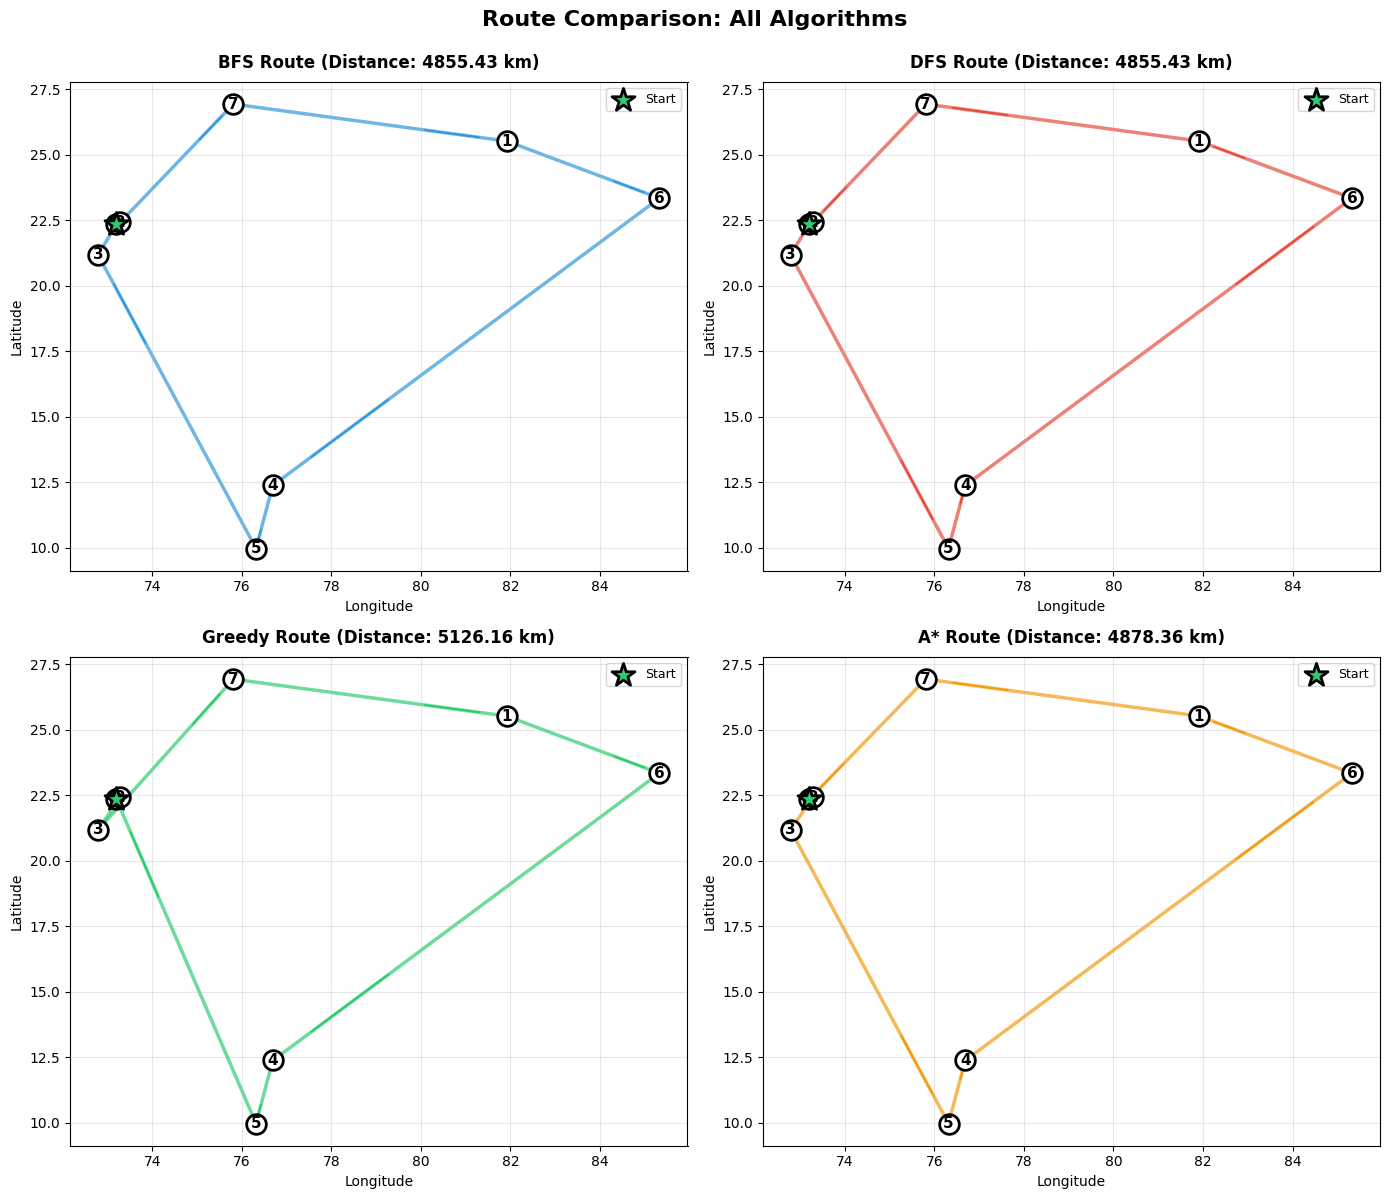

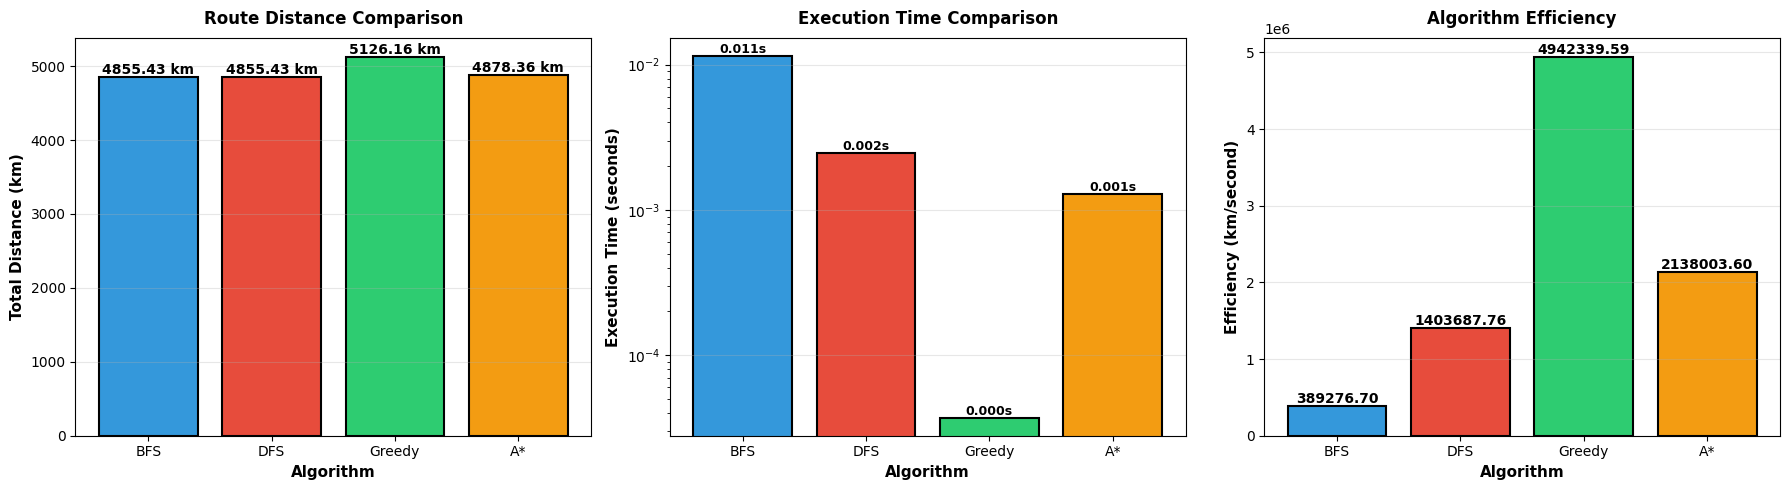


DETAILED ALGORITHM COMPARISON
Algorithm                    Route     Cost_km   Time_s  Nodes_Expanded  Optimal
      BFS [0, 2, 7, 1, 6, 4, 5, 3] 4855.425051 0.011473               8     True
      DFS [0, 3, 5, 4, 6, 1, 7, 2] 4855.425051 0.002459               8     True
   Greedy [0, 2, 3, 7, 1, 6, 4, 5] 5126.161504 0.000037               8    False
       A* [0, 2, 3, 5, 4, 6, 1, 7] 4878.364663 0.001282               8    False

Optimal solution found by: BFS, DFS
Fastest algorithm: Greedy
Most efficient algorithm: Greedy


In [38]:
# Enhanced route visualization with arrows and better styling
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
algorithms = ['BFS','DFS','Greedy','A*']
routes_list = [route_bfs, route_dfs, route_greedy, route_astar]
colors_list = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for ax, algo, route, color in zip(axes, algorithms, routes_list, colors_list):
    lat_lon_route = [coords[i] for i in route] + [coords[0]]
    lats = [x[0] for x in lat_lon_route]
    lons = [x[1] for x in lat_lon_route]
    
    # Plot route with arrows showing direction
    for i in range(len(lat_lon_route) - 1):
        ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], 
               color=color, linewidth=2.5, alpha=0.7, zorder=1)
        # Add arrow
        dx = lons[i+1] - lons[i]
        dy = lats[i+1] - lats[i]
        ax.arrow(lons[i] + 0.7*dx, lats[i] + 0.7*dy, 0.2*dx, 0.2*dy,
                head_width=0.01, head_length=0.01, fc=color, ec=color, zorder=2)
    
    # Mark all locations
    for idx, (lat, lon) in enumerate(coords):
        ax.scatter(lon, lat, c='white', s=200, edgecolors='black', 
                  linewidths=2, zorder=3)
        ax.text(lon, lat, str(idx), fontsize=11, fontweight='bold',
               ha='center', va='center', zorder=4)
    
    # Mark start point
    ax.scatter(lons[0], lats[0], c='#2ecc71', s=300, marker='*', 
              edgecolors='black', linewidths=2, zorder=5, label='Start')
    
    ax.set_title(f'{algo} Route (Distance: {results_df[results_df["Algorithm"]==algo]["Cost_km"].values[0]:.2f} km)', 
                fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.suptitle('Route Comparison: All Algorithms', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Enhanced comparison charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cost comparison with value labels
ax1 = axes[0]
bars1 = ax1.bar(results_df['Algorithm'], results_df['Cost_km'], 
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], 
               edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Total Distance (km)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
ax1.set_title('Route Distance Comparison', fontsize=12, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f} km', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Time comparison with value labels
ax2 = axes[1]
bars2 = ax2.bar(results_df['Algorithm'], results_df['Time_s'], 
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
               edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Execution Time (seconds)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
ax2.set_title('Execution Time Comparison', fontsize=12, fontweight='bold', pad=10)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Efficiency: Distance per second (higher is better)
ax3 = axes[2]
efficiency = results_df['Cost_km'] / (results_df['Time_s'] + 0.001)  # km per second
bars3 = ax3.bar(results_df['Algorithm'], efficiency,
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
               edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Efficiency (km/second)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Algorithm', fontsize=11, fontweight='bold')
ax3.set_title('Algorithm Efficiency', fontsize=12, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison table
print("\n" + "="*70)
print("DETAILED ALGORITHM COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)
print(f"\nOptimal solution found by: {', '.join(results_df[results_df['Cost_km'] == results_df['Cost_km'].min()]['Algorithm'].tolist())}")
print(f"Fastest algorithm: {results_df.loc[results_df['Time_s'].idxmin(), 'Algorithm']}")
print(f"Most efficient algorithm: {results_df.loc[efficiency.idxmax(), 'Algorithm']}")
print("="*70)

### Results Summary

- **BFS/DFS:** Optimal solutions, computationally expensive
- **Greedy:** Fast, near-optimal in this instance
- **A*:** Optimal solution with fewer node expansions (heuristic pruning)
